In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

## 1.5 (a)

In [2]:
def _roc_coords(true_y, y_hat_probs):
  coords = []
  y_and_c = [(y_i, c_i) for y_i, c_i in zip(true_y, y_hat_probs)]
  y_and_c_sorted = sorted(y_and_c, key=lambda x:x[1])
  # sorted i.e. start with a high threshold (all instances as -)
  # => start out with high TNR, low FPR
  neg_num = sum(1 for tup in y_and_c_sorted if tup[0]==0) #True Negatives
  pos_num = sum(1 for tup in y_and_c_sorted if tup[0]==1) #True Positives
  TP, FP = 0, 0
  last_TP = 0
  coords.append([0,0])

  for i in range(len(y_and_c)):
    yi = y_and_c_sorted[i][0]
    ci = y_and_c_sorted[i][1]

    if (i>0) and (ci != y_and_c_sorted[i-1][1]) and (yi==0) and (TP > last_TP):
      # different conf from the previous instance

      # TP > last_TP : different threshold
      FPR = FP/neg_num
      TPR = TP/pos_num
      coords.append([FPR, TPR])
      last_TP = TP

    if (yi==1):
      TP += 1
    else:
      FP += 1

    FPR = FP/neg_num
    TPR = TP/pos_num

  return coords

def plot_roc(ax, true_y, y_hat_probs, label):
    coords = _roc_coords(true_y, y_hat_probs)
    coord_fpr = [coord[0] for coord in coords]
    coord_tpr = [coord[1] for coord in coords]
    coord_fpr.append(1)
    coord_tpr.append(1)
    ax.plot(coord_tpr, coord_fpr, label=label)
    ax.legend()
    plt.grid(True)

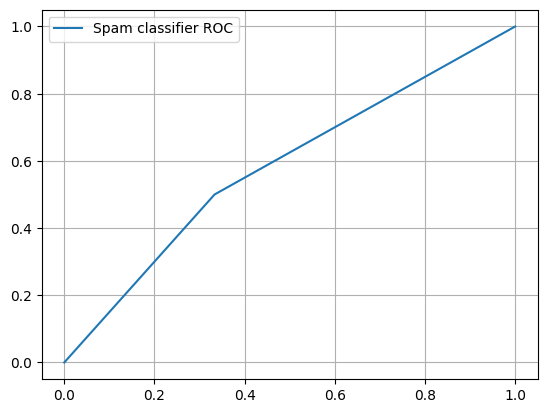

In [4]:
fig, ax = plt.subplots()
correct_classes = [0,0,1,1,0,1,1,0,1,1,]
conf_ones = [0.1, 0.2, 0.3, 0.4, 0.45, 0.55, 0.7, 0.8, 0.85, 0.95]
plot_roc(ax, correct_classes, conf_ones, "Spam classifier ROC")

## 2.1


In [8]:
###REVISED KNN2
#returns prob of positive labels as well if the returnConf feature is turned on
def run_knn(tr_x, tr_y, tt_x, k, returnConf=False):
  x_dist = scipy.spatial.distance.cdist(tr_x, tt_x, metric='euclidean')
  #200 x 41
  # row(train) & col(test)
  top_k_indices = np.argsort(x_dist, axis=0)[:k,:].T
  predictions, confidence = [], []
  for top_k_i in top_k_indices:
    mv_outputs = _majority_vote(tr_y.iloc[top_k_i])
    predictions.append(mv_outputs[0])
    confidence.append(mv_outputs[1])

  if returnConf:
    return predictions,confidence
  else:
    return predictions

#outputs mv along with the probability of positive labels in the neighborhood
def _majority_vote(labels):
  uniq, counts = np.unique(labels, return_counts=True)
  label_counts = dict(zip(uniq, counts))
  mv = max(label_counts, key=lambda key:label_counts[key])
  if 1 in label_counts:
    prob = label_counts[1]/len(labels)
  else:
    prob = 0
  return mv, prob

d2z = pd.read_csv("D2z.txt",header=None, sep=" ")
train_x = d2z.iloc[:,[0,1]]
train_y = d2z.iloc[:,2]
test_x, test_y = np.mgrid[-2:2.1:0.1, -2:2.1:0.1]

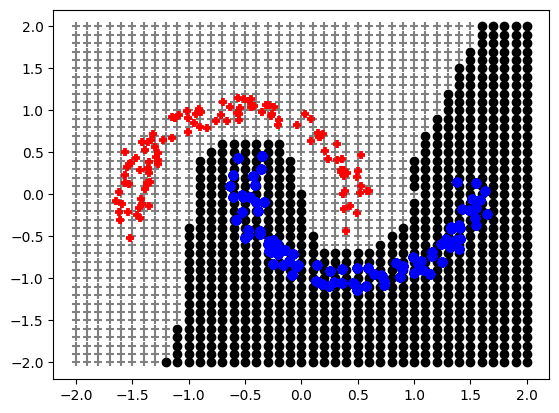

In [10]:
twod_test_x1, twod_test_x2 = np.mgrid[-2:2.1:0.1, -2:2.1:0.1]
d2z = pd.read_csv("D2z.txt",header=None, sep=" ")
train_x = d2z.iloc[:,[0,1]]
train_y = d2z.iloc[:,2]

fig, ax = plt.subplots()
markers = ["+","o"]
colors_train = ["red","blue"]
colors = ["gray","black"]

for i, row in enumerate(twod_test_x1):
  test_i_x = pd.DataFrame({
      0:twod_test_x1[i],
      1:twod_test_x2[i]
  })
  preds = run_knn(train_x, train_y, test_i_x, 1)

  for idx, g in enumerate([1,0]):
    g_idx = np.where(np.array(preds) == g)[0].tolist()
    test_x1_g = test_i_x.iloc[g_idx,0]
    test_x2_g = test_i_x.iloc[g_idx,1]
    ax.scatter(test_x1_g, test_x2_g, marker=markers[idx], c=colors[idx])

    tg_idx = np.where(train_y == g)[0].tolist()
    train_x1_g = train_x.iloc[tg_idx,0]
    train_x2_g = train_x.iloc[tg_idx,1]
    ax.scatter(train_x1_g, train_x2_g, marker = markers[idx], c=colors_train[idx])

In [12]:
emails = pd.read_csv("emails.csv")
cv_k = 5
fold1 = emails[:1000]
fold2 = emails[1000:2000]
fold3 = emails[2000:3000]
fold4 = emails[3000:4000]
fold5 = emails[4000:5000]
folds = [fold1, fold2, fold3, fold4, fold5]

## 2.2

In [13]:
def model_report(i,true_y, pred_y, print_opt=False, returnAcc=True):
  TP = sum((true == 1) and (pred == 1) for true, pred in zip(true_y, pred_y))
  TN = sum((true == 0) and (pred == 0) for true, pred in zip(true_y, pred_y))
  FP = sum((true == 0) and (pred == 1) for true, pred in zip(true_y, pred_y))
  FN = sum((true == 1) and (pred == 0) for true, pred in zip(true_y, pred_y))
  accuracy = (TP + TN) / (TP + TN + FP + FN)
  recall = TP / (TP + FN)
  precision = TP / (TP + FP)

  if print_opt:
    print(f"Fold {i}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Precision: {precision:.2f}\n")

  if returnAcc:
    return accuracy

In [14]:
def run_5_fold_knn_emails(k,modelReportOn=True, returnAccuracy=False):
  # make 5 folds
  fold1 = emails[:1000]
  fold2 = emails[1000:2000]
  fold3 = emails[2000:3000]
  fold4 = emails[3000:4000]
  fold5 = emails[4000:5000]
  folds = [fold1, fold2, fold3, fold4, fold5]
  accuracy_list = []

  # i-fold
  for i in range(5):
    # i-fold : test set
    em_test_i = folds[i]
    em_test_i_x = em_test_i.iloc[:,1:-1]
    em_test_i_y = em_test_i.iloc[:,-1]
    # i-fold: train set
    train_i_list = []
    for j in range(5):
      if j != i:
        train_i_list.append(folds[j])
    em_train_i_df = pd.concat(train_i_list, axis=0) #.reset_index(drop=True)
    em_train_i_x = em_train_i_df.iloc[:,1:-1]
    em_train_i_y = em_train_i_df.iloc[:,-1]

    # run i-fold knn
    em_test_i_y_hat = run_knn(em_train_i_x, em_train_i_y, em_test_i_x, k)

    # model stats
    if modelReportOn:
      model_report(i,em_test_i_y, em_test_i_y_hat,True,False)

    if returnAccuracy:
      acc_i = model_report(i,em_test_i_y, em_test_i_y_hat,False,True)
      accuracy_list.append(acc_i)

  #return acc_list if returnAcuracy
  if returnAccuracy:
    return accuracy_list

In [15]:
run_5_fold_knn_emails(k=1,modelReportOn=True, returnAccuracy=False)

Fold 0
Accuracy: 0.82
Recall: 0.82
Precision: 0.65

Fold 1
Accuracy: 0.85
Recall: 0.87
Precision: 0.69

Fold 2
Accuracy: 0.86
Recall: 0.84
Precision: 0.72

Fold 3
Accuracy: 0.85
Recall: 0.82
Precision: 0.72

Fold 4
Accuracy: 0.78
Recall: 0.76
Precision: 0.61



## 2.3

In [16]:
def compute_loss(pred, true_y):
  zero_loss = true_y*np.log(pred + 1e-9)
  one_loss = (1-true_y)*np.log(1-pred + 1e-9)
  return -np.mean(zero_loss + one_loss)

def _sigmoid(z):
  return np.array([_sigmoid_helper(z_i) for z_i in z])

def _sigmoid_helper(z_i):
  if (z_i >= 0 ):
    return 1/(1+np.exp(-z_i))
  else:
    return np.exp(z_i)/(1+np.exp(z_i))

def train_lr(train_x, true_y, lr, epochs):
  losses = []
  train_x = np.column_stack((np.ones(len(train_x)), train_x)) #add bias term 1
  w = np.random.randn(train_x.shape[1]) #3001 x 1
  #w.shape
  for i in range(epochs):
    pred = _sigmoid(np.matmul(train_x, w)) #4000 x 1
    #gradient = (pred-em_train_i_y).values.reshape(1,4000).T*train_x # (4000 x 3001)
    gradient = np.array([np.mean(grad) for grad in train_x.T*(pred-true_y).values]) # 3001 x 1
    # gradient for each feature
    w -= gradient*lr
    y_hats = [1 if pred_i > 0.5 else 0 for pred_i in pred]
    #true_class: em_trian_i_y
    losses.append(compute_loss(pred, true_y.values.reshape(4000,1)))
  return w


def predict_lr(test_x, w, returnSigmoid=False):
  #test_x = np.column_stack((np.ones(len(test_x)), test_x)) #add bias term 1
  test_x_bias = np.column_stack((np.ones(len(test_x)), test_x))
  pred = _sigmoid(np.matmul(test_x_bias,w))
  if returnSigmoid:
    return [(1, pred_i) if pred_i >0.5 else (0,pred_i) for pred_i in pred]
  return [1 if pred_i >0.5 else 0 for pred_i in pred]

In [17]:
for i in range(5): #i-fold
  #i-fold : test set
  em_test_i = folds[i]
  em_test_i_x = em_test_i.iloc[:,1:-1]
  em_test_i_y = em_test_i.iloc[:,-1]

  #i-fold : train set
  train_i_list = []
  for j in range(5):
    if j != i:
      train_i_list.append(folds[j])
  em_train_i_df = pd.concat(train_i_list, axis=0) #.reset_index(drop=True)
  em_train_i_x = em_train_i_df.iloc[:,1:-1]
  em_train_i_y = em_train_i_df.iloc[:,-1]

  # run log reg
  w_min_loss = train_lr(em_train_i_x, em_train_i_y, lr=0.01,epochs=100)
  em_test_i_y_hat = predict_lr(em_test_i_x, w_min_loss)
  model_report(i,em_test_i_y, em_test_i_y_hat, print_opt=True, returnAcc=False)

Fold 0
Accuracy: 0.64
Recall: 0.77
Precision: 0.42

Fold 1
Accuracy: 0.57
Recall: 0.87
Precision: 0.38

Fold 2
Accuracy: 0.77
Recall: 0.28
Precision: 0.72

Fold 3
Accuracy: 0.65
Recall: 0.33
Precision: 0.39

Fold 4
Accuracy: 0.68
Recall: 0.23
Precision: 0.46



## 2.4

In [18]:
k_list = [1,3,5,7,10]
k_all_accuracy_dict = {}
#knn - varying k
for k in k_list:
  k_accs = run_5_fold_knn_emails(k,modelReportOn=False, returnAccuracy=True)
  k_all_accuracy_dict[k] = k_accs

[0.8344000000000001, 0.841, 0.8418000000000001, 0.8452, 0.8558]


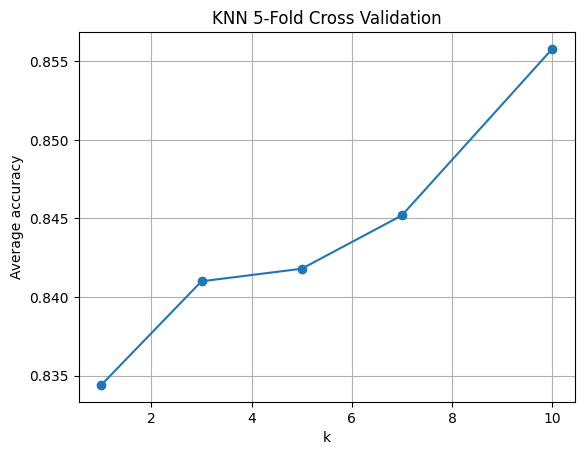

In [19]:
k_mean_accs = [np.mean(k_acc) for k_acc in k_all_accuracy_dict.values()]
k_mean_accs
print(k_mean_accs)
plt.plot(k_list,k_mean_accs, marker="o")
plt.xlabel("k")
plt.ylabel("Average accuracy")
plt.title("KNN 5-Fold Cross Validation")
plt.grid(True)

## 2.5


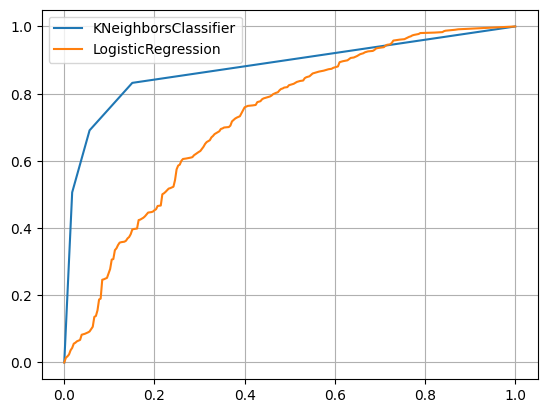

In [22]:
test5 = emails[:1000]
test5_x, test5_y = test5.iloc[:,1:-1], test5.iloc[:,-1]
train5 = emails[1000:]
train5_x, train5_y = train5.iloc[:,1:-1], train5.iloc[:,-1]

test5_yhat_knn, test5_y_pos_prob = run_knn(train5_x, train5_y, test5_x, k=5, returnConf=True)
lr_w = train_lr(train5_x, train5_y, lr=0.01, epochs=100)
test5_lr_outputs = predict_lr(test5_x, lr_w, returnSigmoid=True)


fig, ax = plt.subplots()
plot_roc(ax, test5_y, test5_y_pos_prob, label="KNeighborsClassifier")

test5_lr_pred_probs = [output_i[1] for output_i in test5_lr_outputs]
plot_roc(ax,test5_y, test5_lr_pred_probs, label="LogisticRegression")